In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
%matplotlib inline
!pip install seaborn
!pip install interpret

import seaborn as sns
import plotly.express as px
import random
import datetime as dt
import random
import os
import glob
import random
import zipfile

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
clear_output()

# Load Data

In [2]:
# Set File Paths
PATH_01 = '//content/Train'
PATH_02 = '/content/Test'

In [3]:
train_dirs = glob.glob(PATH_01+ '/*.csv')
train_dirs.sort()
test_dirs = glob.glob(PATH_02+ '/*.csv')
test_dirs.sort()

In [4]:
train_dirs

['//content/Train/2020_01_JAN.csv',
 '//content/Train/2020_02_FEB.csv',
 '//content/Train/2020_03_MAR.csv',
 '//content/Train/2020_04_APR.csv',
 '//content/Train/2020_05_MAY.csv',
 '//content/Train/2020_06_JUN.csv',
 '//content/Train/2020_07_JUL.csv',
 '//content/Train/2020_08_AUG.csv',
 '//content/Train/2020_09_SEP.csv',
 '//content/Train/2020_10_OCT.csv',
 '//content/Train/2020_11_NOV.csv',
 '//content/Train/2020_12_DEC.csv',
 '//content/Train/2021_01_JAN.csv',
 '//content/Train/2021_02_FEB.csv',
 '//content/Train/2021_03_MAR.csv',
 '//content/Train/2021_04_APR.csv',
 '//content/Train/2021_05_MAY.csv',
 '//content/Train/high_freq_2019.csv',
 '//content/Train/production_train.csv']

In [5]:
test_dirs

['/content/Test/2020_01_JAN.csv',
 '/content/Test/2020_02_FEB.csv',
 '/content/Test/2020_03_MAR.csv',
 '/content/Test/2020_04_APR.csv',
 '/content/Test/2020_05_MAY.csv',
 '/content/Test/2020_06_JUN.csv',
 '/content/Test/2020_07_JUL.csv',
 '/content/Test/2020_08_AUG.csv',
 '/content/Test/2020_09_SEP.csv',
 '/content/Test/2020_10_OCT.csv',
 '/content/Test/2020_11_NOV.csv',
 '/content/Test/2020_12_DEC.csv',
 '/content/Test/2021_01_JAN.csv',
 '/content/Test/2021_02_FEB.csv',
 '/content/Test/2021_03_MAR.csv',
 '/content/Test/2021_04_APR.csv',
 '/content/Test/2021_05_MAY.csv',
 '/content/Test/high_freq_2019.csv',
 '/content/Test/production_test.csv']

# Merge Files

In [6]:
# Merge Frequency Files
def concat_data(files):
    
    dataframes = []
    for i in range(len(files)):
        locals()['df'+f'{i}'] = pd.read_csv(files[i],parse_dates=[1])
        dataframes.append(locals()['df'+f'{i}'])
    return pd.concat(dataframes,axis=0).reset_index().drop('index',axis=1)

In [7]:
# Concat High Frequency Data
train = concat_data(train_dirs[:-1])
test = concat_data(test_dirs[:-1])

In [8]:
def perimeter(df):
    values = {'Features:':  df.shape[1], 'Observations:':  '{0:,}'.format(df.shape[0]),
              '%_NaN:': np.round(100* df.isna().sum().sum()/( df.shape[0]* df.shape[1]),1)}

    return pd.DataFrame.from_dict(values, orient='index',columns=['Total'])

In [9]:
perimeter(train)

,Total
Features:,13
Observations:,"8,435,165"
%_NaN:,33.1


In [10]:
perimeter(test)

,Total
Features:,13
Observations:,"1,143,020"
%_NaN:,34.4


In [11]:
train.sample(5)

,WELL_ID,DATE,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,PRESS_INTK,TEMP_INTK,WellFailure
8232193,DEEPWATER-1AD32W,2021-05-17 03:59:22,32.0,3896.0,NaN,223.0,229.0,329.0,NaN,0.0,NaN,NaN,NaN
3729891,DEEPWATER-ISTQBO,2020-10-11 01:10:02,58.0,3829.0,56.0,413.0,223.0,288.0,NaN,0.0,NaN,NaN,NaN
8238456,DEEPWATER-EKA0CA,2021-05-17 10:16:55,21.0,4098.0,57.0,245.0,230.2,258.0,NaN,0.0,NaN,NaN,NaN
4245003,DEEPWATER-M24OXR,2020-10-20 16:14:04,64.0,4117.0,56.0,535.0,233.2,284.0,NaN,0.0,NaN,NaN,NaN
2820077,DEEPWATER-IVXM42,2020-09-14 06:44:41,52.0,3823.0,57.0,298.0,233.6,254.0,NaN,0.0,NaN,NaN,NaN


In [12]:
test.sample(5)

,WELL_ID,DATE,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,PRESS_INTK,TEMP_INTK,WellFailure
1797,DEEPWATER-K0RPBL,2020-01-02 08:00:00,NaN,0.0,NaN,0.0000,-0.000002,-0.000002,NaN,0.000000,NaN,NaN,NaN
438967,DEEPWATER-S5VD4I,2020-09-17 06:01:03,19.000000,3999.0,53.0,1630.0000,230.000000,284.000000,NaN,0.000000,NaN,NaN,NaN
924366,DEEPWATER-UOOXPH,2021-01-15 20:24:44,67.000000,4186.0,58.0,217.0000,227.000000,291.000000,NaN,0.000000,NaN,NaN,NaN
211442,DEEPWATER-F022ZE,2020-05-18 22:07:00,23.799999,NaN,51.0,2188.7000,NaN,270.500000,NaN,NaN,NaN,NaN,NaN
220218,DEEPWATER-F022ZE,2020-05-24 13:00:00,23.799999,NaN,53.0,1725.2999,233.100010,272.500000,NaN,0.200136,NaN,NaN,NaN


### <b>Clue:
##### <b>PRESS_INT & PRESS_INTK</b> refer to the same thing (Intake Pressure), however the second is used only for the values of 2019.
##### <b>TEMP_INT & TEMP_INTK</b> refer to the same thing (Intake Temperature), however the second is used only for the values of 2019.

In [13]:
# Therefore, we can run the next instruction to merge both columns
train['PRESS_INT'] = train['PRESS_INT'].fillna(train['PRESS_INTK'])
train['TEMP_INT'] = train['TEMP_INT'].fillna(train['TEMP_INTK'])

test['PRESS_INT'] = test['PRESS_INT'].fillna(test['PRESS_INTK'])
test['TEMP_INT'] = test['TEMP_INT'].fillna(test['TEMP_INTK'])

# Data Insights

In [14]:
train_wells = train['WELL_ID'].unique()
test_wells = test['WELL_ID'].unique()

print('Train wells: ',len(train_wells))
print('Test wells: ',len(test_wells))

Train wells:  100
Test wells:  15


In [31]:
locations = pd.read_csv('well_locations.csv')

fig = px.scatter(locations, x=locations.lon, y=locations.lat,hover_data=[locations['WELL_ID']])
fig.update_layout(
    width = 1200,
    height = 400,
    title = "Well Locations")

fig.show()

In [22]:
train.describe().round(2)

,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,OUT_VOLT,VIBRATION,PRESS_INTK,TEMP_INTK
count,7925402.00,7888853.00,8122068.00,8165502.00,8035044.00,8130948.00,354864.00,7840173.00,19120.00,19120.00
mean,36.63,3589.59,57.44,1189.48,290.94,275.68,336.48,243.34,2535.62,198.80
std,28.49,2075.57,26.76,7643.48,891.62,142.34,186.67,3979.58,13290.80,218.76
min,0.00,-3276.00,0.00,0.00,-3180.40,-17.78,0.00,0.00,0.00,-17.78
25%,22.00,3653.00,53.00,256.00,226.00,267.60,378.20,0.00,215.38,220.91
50%,33.00,3952.00,56.00,360.00,230.00,284.00,433.90,0.00,346.34,228.25
75%,55.00,4126.00,60.00,709.00,235.00,296.00,458.60,0.00,630.55,238.57
max,51970.00,94906.90,5051.00,189813.80,11827.00,6553.50,953.00,65535.00,94906.90,6553.50


In [37]:
def vizualize_date_vs(df,feature):
    df = df.sort_values(by=['DATE','WELL_ID']).set_index('DATE')
    # For visualization purposes, get ride of outliers from the plots by adding to the mean +-5 times the STD 
    lower_limit, higher_limit = df[feature].mean() - 5*df[feature].std(), df[feature].mean() + 5*df[feature].std()        
    min_idx = list(df.loc[df[feature]<=lower_limit].index.values)
    max_idx = list(df.loc[df[feature]>=higher_limit ].index.values)  
    if len(min_idx)>0:
      df.loc[min_idx,feature] = lower_limit       
    if len(max_idx)>0:
      df.loc[max_idx,feature] = higher_limit
    
    plt.figure(figsize=(15,5))
    plt.plot(df[[feature]])

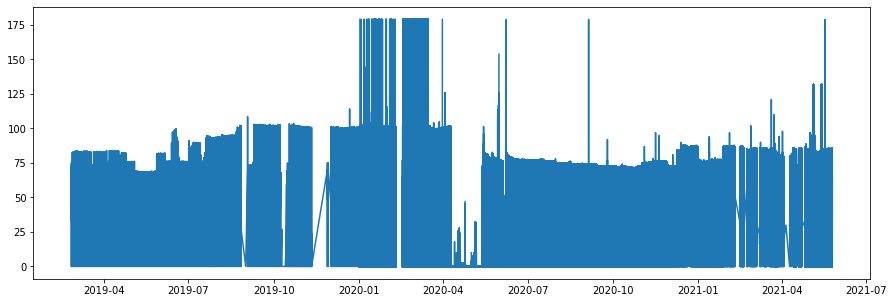

In [38]:
vizualize_date_vs(train,'CURRENT')

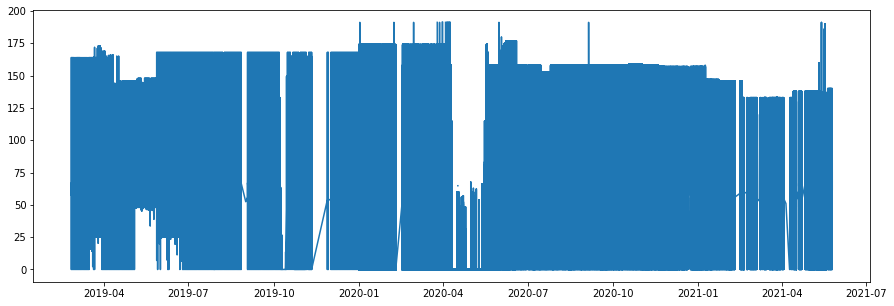

In [39]:
vizualize_date_vs(train,'FREQUENCY')

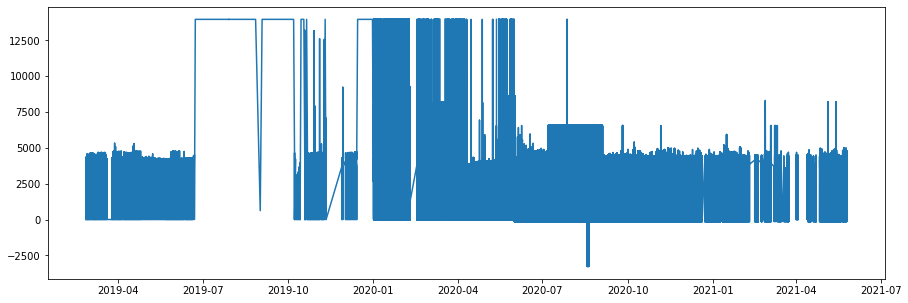

In [40]:
vizualize_date_vs(train,'PRESS_DESC')

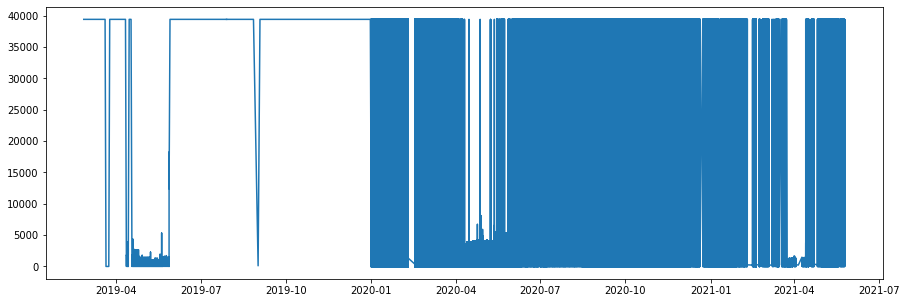

In [41]:
vizualize_date_vs(train,'PRESS_INT')

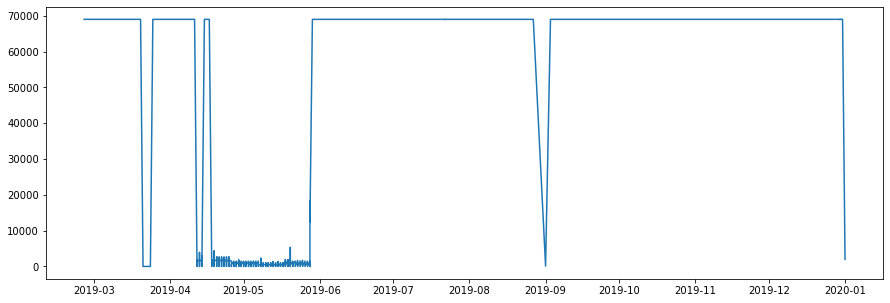

In [ ]:
vizualize_date_vs(train,'PRESS_INTK')

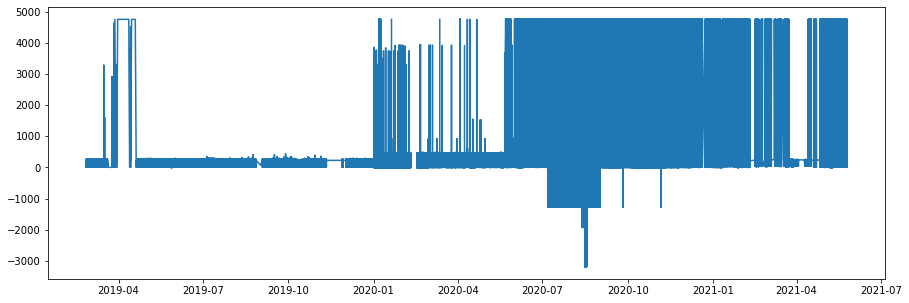

In [ ]:
vizualize_date_vs(train,'TEMP_INT')

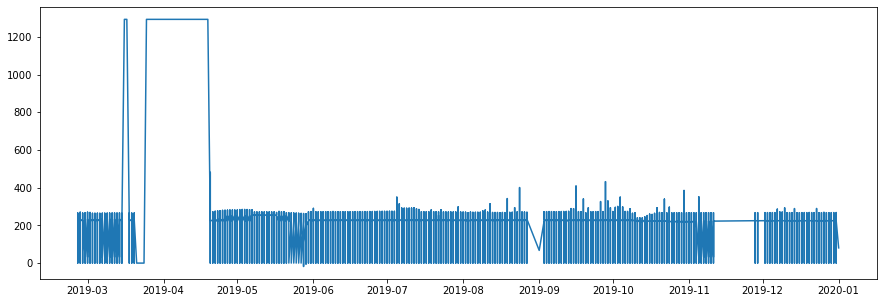

In [ ]:
vizualize_date_vs(train,'TEMP_INTK')

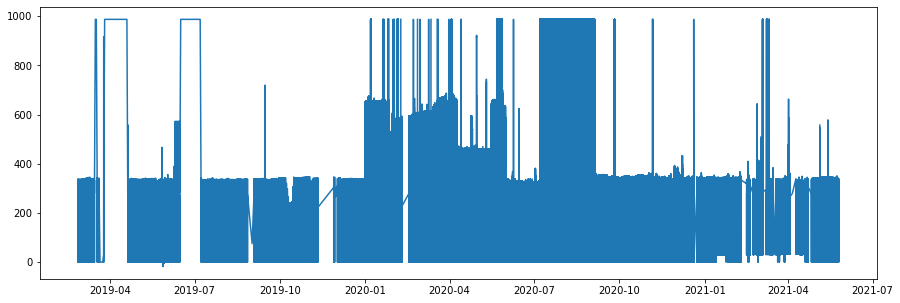

In [ ]:
vizualize_date_vs(train,'TEMP_MOT')

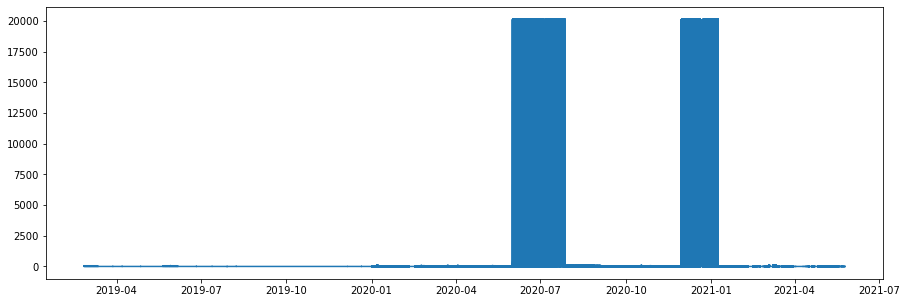

In [ ]:
vizualize_date_vs(train,'VIBRATION')

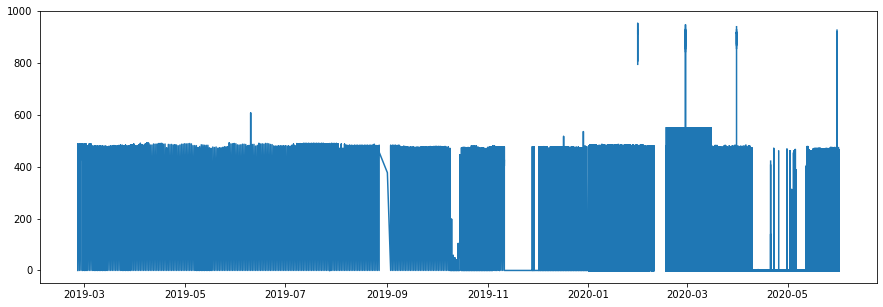

In [ ]:
vizualize_date_vs(train,'OUT_VOLT')

# Input Missing Values

In [42]:
def missings(df):
  data = df.drop(['WELL_ID'],axis=1)
  data_count = data.count()
  fig, ax = plt.subplots(1, 1, figsize=(15, 7))
  ax = sns.barplot(x= data_count.index, y = data_count, palette='crest')
  ax.set_xticklabels(data_count.index, rotation=70) 
  ax.set_yticks([])

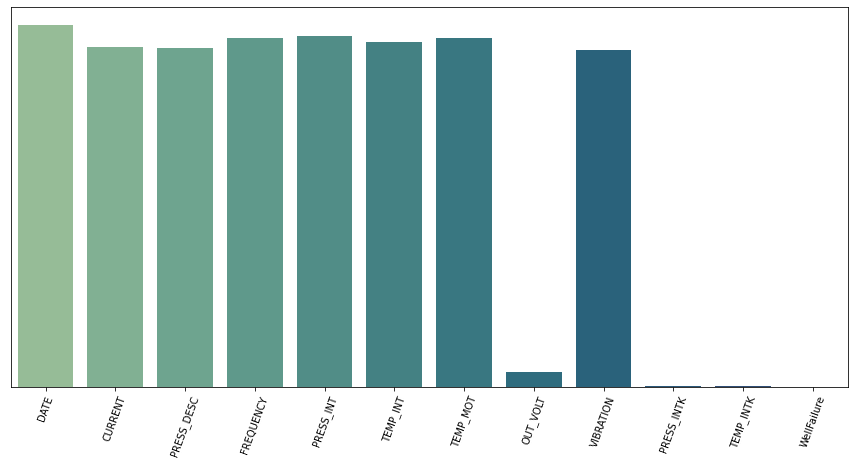

In [43]:
missings(train)

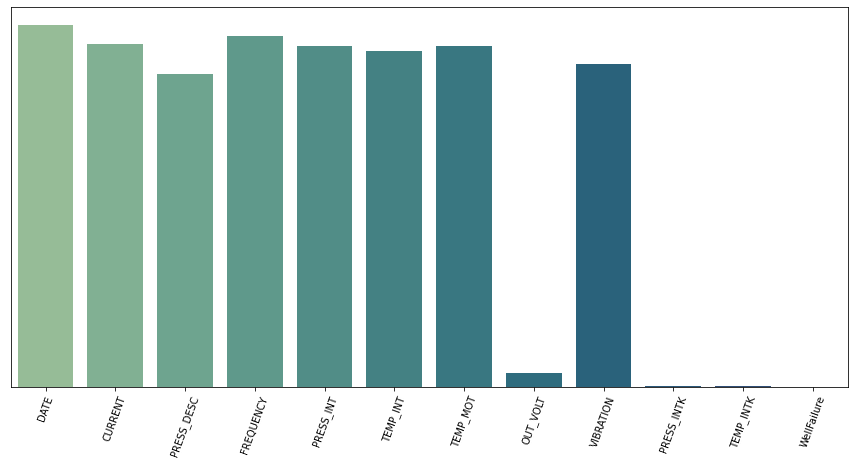

In [44]:
missings(test)

In [45]:
def input_nans(df):    
    df = df.drop(['OUT_VOLT','PRESS_INTK','TEMP_INTK'],axis=1)
    for i in df.keys().drop('WellFailure'):
        df[[i]] = df[[i]].fillna(method='ffill')
        df[[i]] = df[[i]].fillna(method='bfill')
    return df

In [46]:
train = input_nans(train)
test = input_nans(test)

In [47]:
train.isna().sum()

WELL_ID              0
DATE                 0
CURRENT              0
PRESS_DESC           0
FREQUENCY            0
PRESS_INT            0
TEMP_INT             0
TEMP_MOT             0
VIBRATION            0
WellFailure    8435054
dtype: int64

In [48]:
test.isna().sum()

WELL_ID              0
DATE                 0
CURRENT              0
PRESS_DESC           0
FREQUENCY            0
PRESS_INT            0
TEMP_INT             0
TEMP_MOT             0
VIBRATION            0
WellFailure    1143020
dtype: int64

# Predict

In [49]:
from interpret.glassbox import ExplainableBoostingClassifier

In [50]:
# Our Classifier requires a balanced training dataset. Therefore we procced to oversampling the training data.

def shuffle_df(df, random_seed=42):
    return df.sample(frac=1, random_state=random_seed, replace=False)

def oversample(df, y_col, n=None, random_state=42):
    """Sample an equal amount from each class, with replacement"""
    gs = [g for _, g in df.groupby(y_col)]
    if n is None:
        n = max(len(g) for g in gs)

    # sample equal number of each group
    gs = [g.sample(n, random_state=random_state, replace=True) for g in gs]
    # concat, and shuffle
    df = pd.concat(gs, 0)
    df = shuffle_df(df)
    return df

In [51]:
train = train.sort_values(by=['DATE','WELL_ID']).set_index('DATE')
test = test.sort_values(by=['DATE','WELL_ID']).set_index('DATE')

In [52]:
train = oversample(train, "WellFailure", n=600000)

In [53]:
# Split Data
X_train = train.drop(['WellFailure'],axis=1)
y_train = train['WellFailure']

X_test = test.drop(['WellFailure'],axis=1)

In [54]:
model = ExplainableBoostingClassifier(random_state=42, interactions=0)
print(model.fit(X_train, y_train))

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['WELL_ID', 'CURRENT', 'PRESS_DESC',
                                             'FREQUENCY', 'PRESS_INT',
                                             'TEMP_INT', 'TEMP_MOT',
                                             'VIBRATION'],
                              feature_types=['categorical', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous'],
                              inner_bags=0, interactions=0, learning_rate=0.01,
                              mains='all', max_bins=256,
                              max_interaction_bins=32, max_leaves=3,
                              max_rounds=5000, min_samples_leaf=2, n_jobs=-2,
   

In [55]:
y_test_pred = pd.Series(model.predict(X_test),index=test.index)

In [56]:
y_test_pred.unique()

array(['yes', 'Manual off'], dtype=object)

In [57]:
test['WellFailure'] = y_test_pred
test = test.reset_index()
test

,DATE,WELL_ID,CURRENT,PRESS_DESC,FREQUENCY,PRESS_INT,TEMP_INT,TEMP_MOT,VIBRATION,WellFailure
0,2019-02-25 00:00:00,DEEPWATER-0RCI25,59.14,4112.53,53.96,0.00,226.20,274.98,0.00,yes
1,2019-02-25 00:00:00,DEEPWATER-3OKFRE,23.03,3675.48,63.93,253.34,236.45,267.97,0.24,yes
2,2019-02-25 00:00:00,DEEPWATER-4ISLB0,41.21,4009.70,53.00,529.51,223.68,261.97,0.22,Manual off
3,2019-02-25 00:00:00,DEEPWATER-4OBKXS,44.64,0.00,49.00,0.00,0.00,0.00,0.00,Manual off
4,2019-02-25 00:00:00,DEEPWATER-BJE55K,9.37,3717.13,130.00,322.43,231.69,32.00,0.00,yes
...,...,...,...,...,...,...,...,...,...,...
1143015,2021-05-25 09:19:49,DEEPWATER-0RCI25,59.00,4255.00,56.00,228.00,229.00,280.00,0.00,yes
1143016,2021-05-25 09:19:51,DEEPWATER-4ISLB0,58.00,0.00,61.00,0.00,32.00,32.00,0.00,yes
1143017,2021-05-25 09:19:51,DEEPWATER-UOOXPH,67.00,4236.00,58.00,244.00,228.00,301.00,1.00,yes
1143018,2021-05-25 09:19:54,DEEPWATER-GBQGBP,26.00,4096.00,60.00,573.00,248.00,295.00,1.00,yes


In [58]:
result = []
for i in test_wells:
    df = test[test['WELL_ID']==i][['WELL_ID','DATE','WellFailure']].reset_index().drop('index',axis=1)
    result.append(df.sample(1))

result = np.vstack(result)
result = pd.DataFrame(result,columns=['WELL_ID','DATE','WellFailure'])
result

,WELL_ID,DATE,WellFailure
0,DEEPWATER-0RCI25,2020-10-02 01:59:01,yes
1,DEEPWATER-GBQGBP,2020-08-26 00:39:02,yes
2,DEEPWATER-WJW1K1,2020-07-10 12:19:48,yes
3,DEEPWATER-4OBKXS,2021-04-11 23:59:11,yes
4,DEEPWATER-RAPG5L,2020-09-26 06:50:36,Manual off
5,DEEPWATER-BJE55K,2020-11-06 00:31:23,Manual off
6,DEEPWATER-3OKFRE,2020-03-01 00:20:00,Manual off
7,DEEPWATER-S5VD4I,2020-09-23 14:52:01,yes
8,DEEPWATER-HFLRME,2020-02-17 21:00:00,yes
9,DEEPWATER-K0RPBL,2020-01-07 04:00:00,Manual off


In [59]:
# Write the prediction to a zip file
result.to_csv('predictions.csv',index=False)
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")